In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

tf version 2.2.0-rc2 executing eagerly is True
tfp version 0.9.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device_name = tf.test.gpu_device_name()
print("Device name: \"{0}\"".format(device_name))
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

def parser(record):
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32
latent_dim = 100

DB_PATH = BASE_DIR
raw_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

raw_novel = tf.data.TFRecordDataset(DB_PATH + "novel.tfrecords")
parsed_novel = raw_novel.map(parser)

#raw_val = raw_test.shard(2,0)
#raw_test = raw_test.shard(2,1)

parsed_train = raw_train.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#parsed_val = raw_val.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test = raw_test.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
init = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=918273645)

class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim, kernel_initializer=init), # no activation...
        ], name="encode")
    
    @tf.function
    def __call__(self, x):
        mean, logvar = tf.split(self.encode(x), num_or_size_splits=2, axis=1)
        return mean, logvar


class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.decode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),

            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init,
                activation="tanh"),
        ], name="decode")

    @tf.function
    def __call__(self, x):
        return self.decode(x)


@tf.function
def reparameterize(mean, logvar):
    # Logvar used for numerical stability
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean

@tf.function
def generateImg(enc, dec, x):
    mean, logvar = enc(x)
    return generateDist(dec, mean, logvar)

@tf.function
def generateDist(dec, mean, logvar):
    z = reparameterize(mean, logvar)
    return dec(z)

@tf.function
def generatePrecise(enc, dec, x):
    z, _ = enc(x)
    return dec(z)

In [0]:
encOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
decOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)

prior = tfp.distributions.MultivariateNormalDiag(tf.zeros(latent_dim), tf.ones(latent_dim))
N = tf.convert_to_tensor(IMG_HEIGHT * IMG_WIDTH, dtype=tf.float32)
M = tf.convert_to_tensor(BATCH_SIZE, dtype=tf.float32)
reconstructionMult = tf.math.divide(N, M)

@tf.function
def add_noise(x):
    noise_intensity = 1.0
    noise = tf.multiply(noise_intensity, tf.random.normal(shape=x.shape, mean=0.0, stddev=0.3))
    return tf.clip_by_value(tf.add(x, noise), -1.0, 1.0)


#@tf.function
def compute_apply_gradients(enc, dec, x_neutral, x_express, x_other, encOptimizer, decOptimizer, Wkl, C):
    with tf.GradientTape(persistent=True) as tape:
        encloss, decloss = compute_loss(enc, dec,
                                        x_neutral, x_express, x_other,
                                        Wkl, C)

    gradients_of_enc = tape.gradient(encloss, enc.trainable_variables)
    gradients_of_dec = tape.gradient(decloss, dec.trainable_variables)

    encOptimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    decOptimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))


#@tf.function
def compute_loss(enc, dec, x_neutral, x_express, x_other, Wkl, C):
    #Compute loss values
    klLoss, recLoss = compute_ALL_loss(enc, dec,
                                       x_neutral, x_express, x_other)

    # Group them up for each network
    encLoss = tf.math.add(
        tf.math.multiply(
            Wkl, 
            tf.math.abs(tf.math.subtract(klLoss, C))), # Wkl * |kl - C|
        recLoss)
    decLoss = recLoss

    return encLoss, decLoss


#@tf.function
def compute_ALL_loss(enc, dec, x_neutral, x_express, x_other):
    mean_e, logvar_e = enc(x_express)

    # KL Divergence Loss
    posterior = tfp.distributions.MultivariateNormalDiag(mean_e, tf.exp(logvar_e * .5))
    divergenceLoss = tf.reduce_mean(tfp.distributions.kl_divergence(posterior, prior))

    # Reconstruction Loss (RMSE)
    generated_images = generateDist(dec, mean_e, logvar_e)#generated_images_precise = dec(mean_e)
    #reconstructionLoss = tf.math.multiply(reconstructionMult, tf.math.sqrt(tf.reduce_mean(tf.math.square(tf.math.subtract(x_neutral, generated_images)))))
    reconstructionLoss = tf.math.multiply(reconstructionMult, tf.math.sqrt(tf.reduce_mean(tf.math.square(tf.math.subtract(x_express, generated_images)))))

    return divergenceLoss, reconstructionLoss

In [0]:
epochs = 100
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
random_images_for_generation = [image_features['imageExpressive'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]

encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)

In [0]:
# setup checkpoint stuff
checkpoint_dir = BASE_DIR + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckptEpoch{}")
checkpoint = tf.train.Checkpoint(encOptimizer=encOptimizer,
                                 decOptimizer=decOptimizer,
                                 encoder=encoder,
                                 decoder=decoder)

def save_StoicNet(prefix, full=False):
    if prefix is None:
        path_to_save = BASE_DIR + "saved_model"
    else:
        path_to_save = BASE_DIR + "saved_model/{}".format(prefix)
    !mkdir -p "{path_to_save}"
    print('Saving model at "{}"'.format(path_to_save))
    if full:
        encoder.save(path_to_save + "/encoder.h5")
        decoder.save(path_to_save + "/decoder.h5")
    else:
        encoder.save_weights(path_to_save + "/encoder.h5")
        decoder.save_weights(path_to_save + "/decoder.h5")


def load_StoicNet(prefix):
    if prefix is None:
        path_to_save = BASE_DIR + "saved_model"
    else:
        path_to_save = BASE_DIR + "saved_model/{}".format(prefix)

    encoder.load_weights(path_to_save + "/encoder.h5")
    decoder.load_weights(path_to_save + "/decoder.h5")

In [0]:
def save_images(epoch, test_input):
    imgs = decoder(test_input)
    assert not np.any(np.isnan(imgs))
    fig = plt.figure(figsize=(4,4))
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    #plt.close(fig)

def display_novel_images():
    for image_features in parsed_novel:
        first = image_features['imageNeutral']
        second = image_features['imageExpressive']
        third = image_features['imageOther']
        test_input = np.array([first, second, third])

        images = generatePrecise(encoder, decoder, test_input[0:3])
        ims = np.concatenate((test_input[0:3], images), axis=0)
        assert not np.any(np.isnan(ims))
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6,4))
        for i in range(ims.shape[0]):
            c = i % 3
            r = i // 3
            axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
            axes[r, c].set_yticklabels([])
            axes[r, c].xaxis.set_visible(False)
        axes[0,0].set_ylabel("Inputs", size='large')
        axes[1,0].set_ylabel("Generated", size='large')
        fig.tight_layout()
        plt.savefig('novel_outputs.png')

def display_imgs_ratings(test_input, epoch=-1):
    images = generateImg(encoder, decoder, test_input[0:8])
    ims = np.concatenate((test_input[0:8], images), axis=0)
    assert not np.any(np.isnan(ims))
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(11,4))
    for i in range(ims.shape[0]):
        c = i % 8
        r = i // 8
        axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
        axes[r, c].set_yticklabels([])
        axes[r, c].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Inputs", size='large')
    axes[1,0].set_ylabel("Generated", size='large')
    fig.tight_layout()
    if epoch >= 0:
        plt.savefig('gens_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()

def plot_ALL_loss(ls):
    kl, rl = zip(*ls)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(kl, '-b', label='kL')
    plt.plot(rl, '-g', label='rL')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


def display_feature_changes():
    steps = 15
    magnitude = 3.0

    # Build the feature vectors
    vectors = np.zeros(shape=[steps*2+1, latent_dim, latent_dim])
    for step in range(-1*steps, steps+1):
        step_index = step + steps
        mag = magnitude * (step/steps)
        for feature_index in range(0, latent_dim):
            vectors[step_index, feature_index, feature_index] = mag
    print(vectors)

    # Make the images
    for step_index in range(0, steps*2+1):
        print("Generating frame {}".format(step_index))
        encoding = vectors[step_index]
        imgs = decoder(encoding)
        assert not np.any(np.isnan(imgs))
        fig = plt.figure(figsize=(10,10))
        for i in range(imgs.shape[0]):
            plt.subplot(10, 10, i+1)
            plt.imshow(imgs[i, :, :, 0], cmap='gray')
            plt.axis('off')
        fig.tight_layout()
        plt.savefig('frame_{}.png'.format(step_index))
        plt.close(fig)

    # Make the animation
    anim_filename = BASE_DIR + 'TrainingGifs/feature_changes_' + time.strftime('%l:%M_%b_%d') + '.gif'
    print("Saving gif at: " + anim_filename)
    with imageio.get_writer(anim_filename, mode='I') as writer:
        filenames = glob.glob('frame_*.png')
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
    
    print("Done")

# Training Stuff

In [0]:
FRESH = True
if not FRESH:
    load_StoicNet("TEMP_SAVE")
else:
    print("Training a fresh model")
    startEpoch = 0

Training a fresh model


Epoch 28, Total epoch time 45.2
Losses: k 0.24016(50.0x0.00480+0.0)  r 166.49957


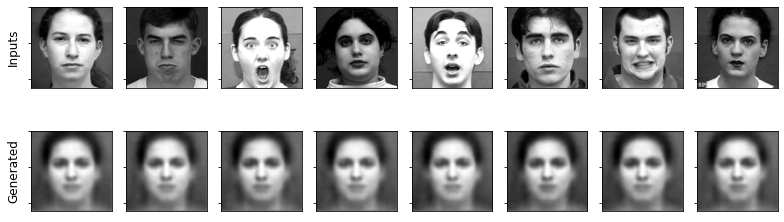

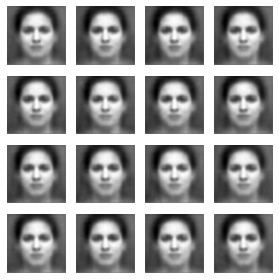

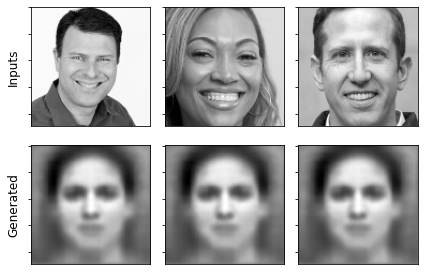

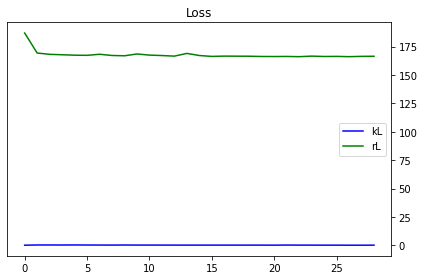


Training........................................

In [0]:
# Wkl (aka beta) weighs KL Divergence loss, limiting encoding capacity 
Wkl = tf.convert_to_tensor(5.0, dtype=tf.float32)     
max_Wkl = 1.0
Wkl_ramp_start = -1   # Ramps up
Wkl_ramp_end = 10

# C adds capacity to the encoding
C = tf.convert_to_tensor(0.0, dtype=tf.float32)     
max_C = 25.0
C_ramp_start = 5   # Ramps up
C_ramp_end = 55


ls = []
bestLoss = 999999.9
start_time = time.time()
for epoch in range(startEpoch, epochs-startEpoch):
    # Train
    print("\nTraining", end="")
    
    batchCounter = 0
    #Wkl = min(max_Wkl, max_Wkl * (max(0, (epoch - Wkl_ramp_start)) / Wkl_ramp_end))
    #Wkl = tf.convert_to_tensor(Wkl, dtype=tf.float32)
    #C = min(max_C, max_C * (max(0, (epoch - C_ramp_start)) / C_ramp_end))
    #C = tf.convert_to_tensor(C, dtype=tf.float32)

    for image_features in parsed_train:
        neutral_raw = image_features['imageNeutral']
        expressive_raw = image_features['imageExpressive']
        other_raw = image_features['imageOther']

        compute_apply_gradients(
            encoder, decoder,
            neutral_raw, expressive_raw, other_raw,
            encOptimizer, decOptimizer,
            Wkl, C)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    
    # Test
    print("\nTesting", end="")
    batchCounter = 0
    kloss = tf.keras.metrics.Mean()
    rloss = tf.keras.metrics.Mean()
    for image_features in parsed_test:
        neutral_raw = image_features['imageNeutral']
        expressive_raw = image_features['imageExpressive']
        other_raw = image_features['imageOther']

        kl, rl = compute_ALL_loss(
            encoder, decoder,
            neutral_raw, expressive_raw, other_raw)
        
        kloss(kl)
        rloss(rl)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")

    kl_base = kloss.result().numpy()
    kl = tf.add(tf.math.multiply(kloss.result(), Wkl), C).numpy()
    rl = rloss.result().numpy()
    ls = ls + [(kl, rl)]
    
    save_StoicNet("TEMP_SAVE")
    end_time = time.time()

    # Output
    display.clear_output(wait=False)
    print('Epoch {0}, Total epoch time {1:.1f}'.format(epoch, end_time-start_time))
    print('Losses: k {0:.5f}({1:.1f}x{2:.5f}+{3:.1f})  r {4:.5f}'.format(
            kl, Wkl, kl_base, C, rl))
    display_imgs_ratings(random_images_for_generation)
    save_images(epoch, random_vector_for_generation)
    display_novel_images()
    plot_ALL_loss(ls)


    # Save the model from time to time or if you get a new record (after sufficient training)
    if epoch > 20 and kl + rl < bestLoss:
        bestLoss = kl + rl
        save_StoicNet("TEMP_BEST_MODEL")
        print("*Saved new best*")
    elif (epoch + 1) % 10 == 0:
        save_StoicNet("TEMP_SAVE")

    tf.keras.backend.clear_session()
    start_time = time.time()

In [0]:
save_StoicNet("FINAL_SAVE_"+time.strftime('%l_%M_%b%d'))

In [0]:
display_feature_changes()

In [0]:
anim_filename = BASE_DIR + 'TrainingGifs/vaegan' + time.strftime('%l:%M %b %d') + '.gif'
print(anim_filename)
with imageio.get_writer(anim_filename, mode='I') as writer:
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Testing Stuff

In [0]:
checkpointName = "ckpt-4" # "FINAL_CKPT_12:05Mar22-18"
#checkpoint.restore(os.path.join(checkpoint_dir,checkpointName)).assert_nontrivial_match()

In [0]:
display_imgs_ratings(random_images_for_generation)

In [0]:
display_novel_images()
print(encoder(test_input))

In [0]:
save_images(-1, tf.math.scalar_mul(-0.8, tf.ones_like(random_vector_for_generation)))